<a href="https://colab.research.google.com/github/jypkec/pytorch/blob/master/caltech_256_transfer_learning_10_epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
!wget https://caltech256-bucket.s3.amazonaws.com/256_ObjectCategories.tar
!tar -xf 256_ObjectCategories.tar



--2023-05-19 07:26:43--  https://caltech256-bucket.s3.amazonaws.com/256_ObjectCategories.tar
Resolving caltech256-bucket.s3.amazonaws.com (caltech256-bucket.s3.amazonaws.com)... 52.216.20.64, 3.5.29.187, 52.216.161.107, ...
Connecting to caltech256-bucket.s3.amazonaws.com (caltech256-bucket.s3.amazonaws.com)|52.216.20.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1183006720 (1.1G) [application/x-tar]
Saving to: ‘256_ObjectCategories.tar’

256_ObjectCategorie 100%[===================>]   1.10G  67.0MB/s    in 16s     

2023-05-19 07:26:59 (71.3 MB/s) - ‘256_ObjectCategories.tar’ saved [1183006720/1183006720]



In [4]:
import glob
from sklearn.preprocessing import LabelEncoder
!pip install Pillow

dataset_path = './256_ObjectCategories'
all_images = glob.glob(f'{dataset_path}/*/*.jpg')
all_labels = [os.path.basename(os.path.dirname(img)) for img in all_images]

# Train-test split
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels)


print(type(train_images[0]))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
<class 'str'>


In [5]:
print(type(train_images[0]))
print(type(test_labels[0]))
print((test_labels[0]))
print((train_images[0]))


<class 'str'>
<class 'str'>
209.sword
./256_ObjectCategories/034.centipede/034_0045.jpg


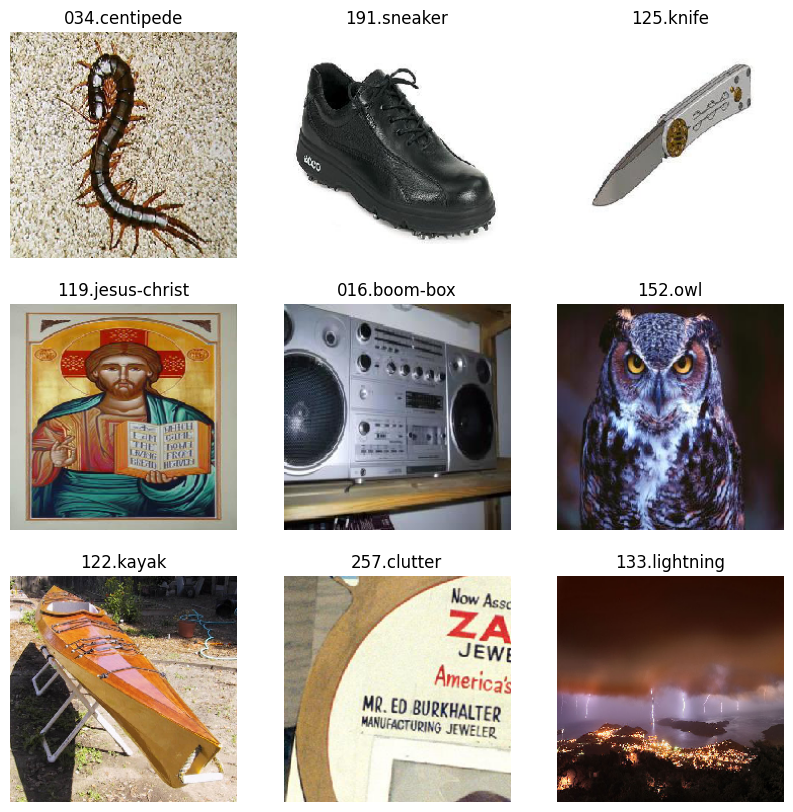

In [6]:
import matplotlib.pyplot as plt

#class_names = train_labels.class_names

plt.figure(figsize=(10, 10))
#for images, labels in train_dataset.take(1):
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img=tf.keras.preprocessing.image.load_img(train_images[i], target_size=(224, 224))
  plt.imshow(img)
  plt.title(train_labels[i])
  plt.axis("off")


In [7]:
img_size = 224
batch_size = 32

def train_data_generator(images, labels, batch_size):
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    num_classes = len(encoder.classes_)
    
    while True:
        idx = np.random.permutation(len(images))
        for i in range(0, len(images), batch_size):
            batch_idx = idx[i:i+batch_size]
            batch_images = [tf.keras.preprocessing.image.load_img(img, target_size=(img_size, img_size)) for img in np.array(images)[batch_idx]]
            batch_x = np.array([tf.keras.preprocessing.image.img_to_array(img) for img in batch_images]) / 255.0
            batch_y = tf.keras.utils.to_categorical(encoded_labels[batch_idx], num_classes)
            yield batch_x, batch_y

def test_data_generator(images, labels, batch_size):
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    num_classes = len(encoder.classes_)
    
    while True:
        idx = np.arange(len(images))
        for i in range(0, len(images), batch_size):
            batch_idx = idx[i:i+batch_size]
            batch_images = [tf.keras.preprocessing.image.load_img(img, target_size=(img_size, img_size)) for img in np.array(images)[batch_idx]]
            batch_x = np.array([tf.keras.preprocessing.image.img_to_array(img) for img in batch_images]) / 255.0
            batch_y = tf.keras.utils.to_categorical(encoded_labels[batch_idx], num_classes)
            yield batch_x, batch_y

train_generator = train_data_generator(train_images, train_labels, batch_size)
test_generator = test_data_generator(test_images, test_labels, batch_size)

In [8]:
epochs = 10
steps_per_epoch = len(train_images) // batch_size
validation_steps = len(test_images) // batch_size


In [9]:
densenet =tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)


29084464/29084464 [==============================] - 0s 0us/step


In [10]:
densenet.trainable = True

for layer in densenet.layers:
  if 'conv5_block1' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

In [11]:
densenet.summary()


Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                     

In [12]:
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras import layers
from tensorflow import keras

model = Sequential()
model.add(densenet)
model.add(tf.keras.layers.Dropout(0.3))
model.add(keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.3))


model.add(layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(layers.Dense(257, activation='softmax'))


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 dropout (Dropout)           (None, None, None, 1024)  0         
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                        

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)


In [16]:
history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=test_generator, validation_steps=validation_steps, verbose=1,callbacks=[earlystopping])


Epoch 1/10
765/765 [==============================] - 179s 196ms/step - loss: 3.9813 - accuracy: 0.2424 - val_loss: 1.5964 - val_accuracy: 0.6702
Epoch 2/10
765/765 [==============================] - 161s 210ms/step - loss: 1.8328 - accuracy: 0.5670 - val_loss: 0.9862 - val_accuracy: 0.7677
Epoch 3/10
765/765 [==============================] - 162s 212ms/step - loss: 1.3117 - accuracy: 0.6799 - val_loss: 0.8181 - val_accuracy: 0.7932
Epoch 4/10
765/765 [==============================] - 163s 214ms/step - loss: 1.0500 - accuracy: 0.7329 - val_loss: 0.7474 - val_accuracy: 0.8076
Epoch 5/10
765/765 [==============================] - 160s 209ms/step - loss: 0.8819 - accuracy: 0.7705 - val_loss: 0.7079 - val_accuracy: 0.8197
Epoch 6/10
765/765 [==============================] - 160s 210ms/step - loss: 0.7643 - accuracy: 0.7976 - val_loss: 0.6817 - val_accuracy: 0.8253
Epoch 7/10
765/765 [==============================] - 143s 186ms/step - loss: 0.6549 - accuracy: 0.8255 - val_loss: 0.6647 -

In [17]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=validation_steps)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

191/191 [==============================] - 26s 135ms/step - loss: 0.6496 - accuracy: 0.8406
Test loss: 0.6496
Test accuracy: 0.8406


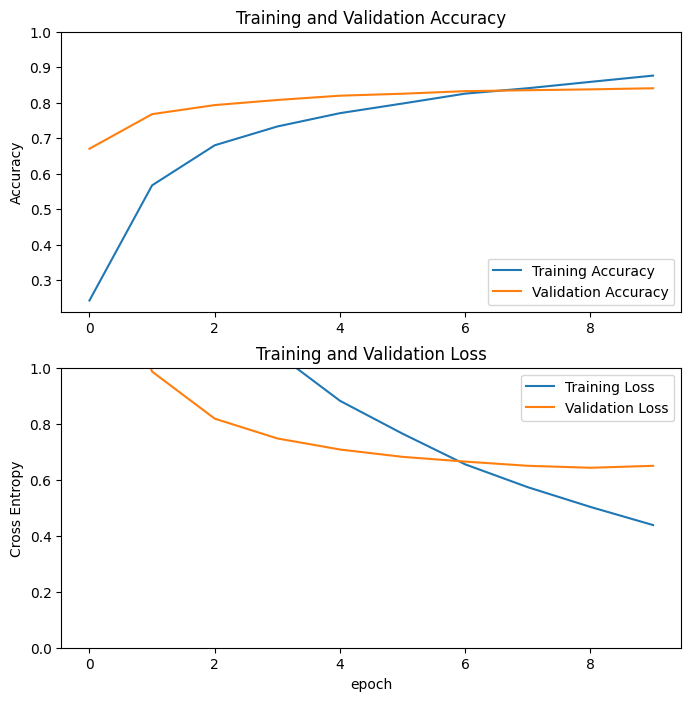

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()